In [1]:
# this was necessary to install the imputeLCMD package

# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install(c("pcaMethods", "impute"))

# install.packages("imputeLCMD")

In [2]:
# specifying the location of files to be exported on my computer
Output <- ("/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1007. Proteomic Smoke Screen Workshop/P1007.3. Analyses/P1007.3.1. Data Processing/Output")

# it's always a good idea to update the date every time the file is modified
cur_date <- "0100522"

# loading packages
library(readxl)
library(tidyverse)
library(imputeLCMD)
library(factoextra)

# reading in files
demographics_df <- data.frame(read_excel("Input/SubjectInfo_100422.xlsx", sheet = 2))
proteomics_df <- data.frame(read_excel("Input/Proteomics_Data_100422.xlsx", sheet = 2))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: tmvtnorm

Loading required package: mvtnorm

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loading required package: stats4

Loading required package: gmm

Loading required package: sandwich

Loading required package: norm

This package has some major limitations
(for example, it does not work reliably when
the number of variables exceeds 30),
and has been superseded by the norm2 package.

Loading required package: pcaMethods

Loading required package: Biobase

Loading require

In [3]:
# let's view our data
head(demographics_df)
head(proteomics_df)

,Original_Subject_Number,Proteomic_Core_Subject_Number,Subject_Number,Subject_ID,Sex,Race,Ethnicity,Age,BMI,Asthma_Status,Pre_Sputum_Neutrophilia,Post_Sputum_Neutrophilia,Responder_Status
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
1,1,1,1,NR_1,M,B,NH,37,26.0,NAS,77.20,74.49,NR
2,6,3,2,NR_2,F,W,NH,26,21.9,NAS,22.60,0.00,NR
3,11,9,3,NR_3,M,W,NH,33,23.9,NAS,68.39,0.00,NR
4,16,15,4,NR_4,F,W,NH,30,23.3,NAS,34.63,22.72,NR
5,23,23,5,NR_5,M,As,NH,29,19.6,NAS,28.60,79.70,NR
6,28,29,6,NR_6,F,W,NH,31,21.1,NAS,50.00,0.00,NR


,Protein_Accession,Gene_Name,Protein_Descriptions,Protein_Name,Number_Unique_Peptides,NR_1.Post_1,NR_1.Pre_2,NR_2.Post_3,NR_2.Pre_4,R_16.Post_5,⋯,NR_15.Post_45,NR_15.Pre_46,R_26.Post_47,R_26.Pre_48,R_28.Post_49,R_28.Pre_50,NR_10.Post_51,NR_10.Pre_52,NR_11.Post_53,NR_11.Pre_54
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,64819128,88131664,30396704,38267072,68394088,⋯,101923184,60452100,80559896,58957400,76130320,74376768,65792688,194960864,69929272,78145128
2,P01877,IGHA2,Immunoglobulin heavy constant alpha 2,IGHA2_HUMAN,26,22060250,42064988,15816474,13573791,41635244,⋯,25832360,17997114,51021916,33093636,31312154,27951066,47788776,50067800,87764504,50257404
3,P01876,IGHA1,Immunoglobulin heavy constant alpha 1,IGHA1_HUMAN,19,15479590,37625912,10208903,17411216,26743002,⋯,32377382,16222550,45050984,25297714,26496618,22352402,35715656,48121812,34948236,26980310
4,P02768,ALB,Albumin,ALBU_HUMAN,111,24605874,15046185,3849758,10269878,37167876,⋯,23754696,35173596,12769630,12790221,12739557,20100892,25795572,53819984,11479106,33682988
5,P01834,IGKC,Immunoglobulin kappa constant,IGKC_HUMAN,3,10251611,23780070,5838666,11111163,17627460,⋯,20500068,17385894,21898422,15646760,17069230,7808116,12224238,26033636,8252182,17545114
6,P0DTE7;P0DTE8;P0DUB6,AMY1B;AMY1C;AMY1A,Alpha-amylase 1B;Alpha-amylase 1C;Alpha-amylase 1A,AMY1B_HUMAN;AMY1C_HUMAN;AMY1A_HUMAN,43,15135001,4211979,121132528,12570474,4974127,⋯,3932507,4589779,12964920,20496752,9089169,20601276,7792469,21065250,2210601,7292686


# 1. Removing Subject Outliers

Our `demographics_df`contains 3 subjects (NR_4, NR_9, and R_27) that there were deemed as outliers and need to be removed. (This was due to blood contamination and low expression.) The `filter`function will be used to remove these three subjects.

In [4]:
# creating a vector with the subject ids of the outliers
outlier_subjects <- c("NR_4", "NR_9", "R_27")

# creating a variable that does the opposite of '%in%'
`%notin%` <- Negate(`%in%`)

# removing outliers using the filter function
demographics_df_no_outliers <- demographics_df %>%
    # filtering for subjects not in the outlier_subjects vector
    filter(Subject_ID %notin% outlier_subjects)

#let's check to see if they were removed
dim(demographics_df)
dim(demographics_df_no_outliers)

[1] 30 13

[1] 27 13

The `dim` function provides the length (first number) and width (second number) of our data. Since, each subject has one row of information we can see that we now have 3 fewer subjects. 

# 2. Reshaping & Merging Dataframes

Our `demographics_df`is in a long format, but our `proteomics_df`is in a wide format. Notice that the `proteomics_df` has column names that contains both the subject ID and time point of data collection. Both of those variables are important to us and would be easier to work with if the subject ID and time point and their own separate columns. Let's do that using the function `pivot_longer`!

In [5]:
# telling the pivot_longer function to only pivot the concentration data (columns 6 through 61)
# the two columns for the names and values can be renamed 
longer_proteomics_df <- pivot_longer(proteomics_df, cols = 6:59, names_to = "Subject_ID.Sample_ID", 
                                    values_to = "Intensity")

# viewing data
head(longer_proteomics_df)

Protein_Accession,Gene_Name,Protein_Descriptions,Protein_Name,Number_Unique_Peptides,Subject_ID.Sample_ID,Intensity
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,NR_1.Post_1,64819128
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,NR_1.Pre_2,88131664
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,NR_2.Post_3,30396704
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,NR_2.Pre_4,38267072
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,R_16.Post_5,68394088
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,R_16.Pre_6,50484084


The subject ids and sample ids are still merged together in one column, so we'll create two separate columns for each variable using the `separate` function.

In [6]:
longer_proteomics_separated_df <- longer_proteomics_df %>%
    # in the separate function a period needs to be specified by "\\." not "."
    # the second parameter is used to specify the new column names
    separate(Subject_ID.Sample_ID, c("Subject_ID", "Sample_ID"), sep = "\\.")

# viewing data
head(longer_proteomics_separated_df)

Warning message:
“Expected 2 pieces. Additional pieces discarded in 2244 rows [7, 61, 115, 169, 223, 277, 331, 385, 439, 493, 547, 601, 655, 709, 763, 817, 871, 925, 979, 1033, ...].”


Protein_Accession,Gene_Name,Protein_Descriptions,Protein_Name,Number_Unique_Peptides,Subject_ID,Sample_ID,Intensity
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,NR_1,Post_1,64819128
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,NR_1,Pre_2,88131664
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,NR_2,Post_3,30396704
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,NR_2,Pre_4,38267072
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,R_16,Post_5,68394088
P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,R_16,Pre_6,50484084


Now we can use the `Subject_ID` column to merge the `demographics_df` and `final_proteomics_df` using the `inner_join`function.

We're also going to remove the `Original_Subject_Number` and the `Proteomic_Core_Subject_Number` since they're no longer needed.

In [7]:
# square brackets can be used in R to subset dataframes
# the left side of the comma selects rows and the right side selects columns
# below we're telling the computer to keep all the rows, but only keep columns 3 through 20
proteomics_demographics_df <- inner_join(demographics_df, longer_proteomics_separated_df)[,3:20]

# viewing data
head(proteomics_demographics_df)

Joining, by = "Subject_ID"


,Subject_Number,Subject_ID,Sex,Race,Ethnicity,Age,BMI,Asthma_Status,Pre_Sputum_Neutrophilia,Post_Sputum_Neutrophilia,Responder_Status,Protein_Accession,Gene_Name,Protein_Descriptions,Protein_Name,Number_Unique_Peptides,Sample_ID,Intensity
,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>
1,1,NR_1,M,B,NH,37,26,NAS,77.2,74.49,NR,P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,Post_1,64819128
2,1,NR_1,M,B,NH,37,26,NAS,77.2,74.49,NR,P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,Pre_2,88131664
3,1,NR_1,M,B,NH,37,26,NAS,77.2,74.49,NR,P01877,IGHA2,Immunoglobulin heavy constant alpha 2,IGHA2_HUMAN,26,Post_1,22060250
4,1,NR_1,M,B,NH,37,26,NAS,77.2,74.49,NR,P01877,IGHA2,Immunoglobulin heavy constant alpha 2,IGHA2_HUMAN,26,Pre_2,42064988
5,1,NR_1,M,B,NH,37,26,NAS,77.2,74.49,NR,P01876,IGHA1,Immunoglobulin heavy constant alpha 1,IGHA1_HUMAN,19,Post_1,15479590
6,1,NR_1,M,B,NH,37,26,NAS,77.2,74.49,NR,P01876,IGHA1,Immunoglobulin heavy constant alpha 1,IGHA1_HUMAN,19,Pre_2,37625912


# 3. Peptide Normalization

Biologically speaking, proteomics normalization is to "correct for variability that is not coming from the biological system itself, but from th experimental process" [ref](https://help2.biognosys.com/portal/en/kb/articles/how-is-my-data-normalized-in-spectronaut#:~:text=Default%20normalization%20in%20Spectronaut,-Spectronaut%20default%20settings&text=This%20default%20normalization%20is%20based,peptides%20up%20and%20down%20regulated). Statistically speaking, normalization is used to put all variables on the same scale between 0 and 1. We normalize to total amount of peptide per sample by: 

1. Summing the abundance values for each sample
2. Calculating the median value across all of the summed abundance values
3. Calculating the ratio

In our dataset, we'll create a new column of normalized values. Let's call it `Norm_Intensity`, which is short for normalized concentration. We can create a new column using the `mutate`function.

When creating variables names, keep in mind that they should be descriptive and relevant to the data it contains.

In [8]:
normalized_df <- proteomics_demographics_df %>%
    # grouping by sample
    group_by(Sample_ID) %>%
    # taking the sum of the intensities for each sample
    mutate(Summed_Value = sum(Intensity)) %>%
    # calculating median across all samples 
    ungroup() %>%
    mutate(Median_of_Sum = median(Summed_Value), Norm_Factor = Summed_Value/ Median_of_Sum, 
           Norm_Intensity = Intensity/Norm_Factor) %>%
    # using the select function to remove columns we no longer need
    select(-c("Summed_Value", "Median_of_Sum", "Norm_Factor"))

# viewing data
head(normalized_df)

Subject_Number,Subject_ID,Sex,Race,Ethnicity,Age,BMI,Asthma_Status,Pre_Sputum_Neutrophilia,Post_Sputum_Neutrophilia,Responder_Status,Protein_Accession,Gene_Name,Protein_Descriptions,Protein_Name,Number_Unique_Peptides,Sample_ID,Intensity,Norm_Intensity
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
1,NR_1,M,B,NH,37,26,NAS,77.2,74.49,NR,P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,Post_1,64819128,73788698
1,NR_1,M,B,NH,37,26,NAS,77.2,74.49,NR,P61626,LYZ,Lysozyme C,LYSC_HUMAN,21,Pre_2,88131664,81867432
1,NR_1,M,B,NH,37,26,NAS,77.2,74.49,NR,P01877,IGHA2,Immunoglobulin heavy constant alpha 2,IGHA2_HUMAN,26,Post_1,22060250,25112913
1,NR_1,M,B,NH,37,26,NAS,77.2,74.49,NR,P01877,IGHA2,Immunoglobulin heavy constant alpha 2,IGHA2_HUMAN,26,Pre_2,42064988,39075088
1,NR_1,M,B,NH,37,26,NAS,77.2,74.49,NR,P01876,IGHA1,Immunoglobulin heavy constant alpha 1,IGHA1_HUMAN,19,Post_1,15479590,17621631
1,NR_1,M,B,NH,37,26,NAS,77.2,74.49,NR,P01876,IGHA1,Immunoglobulin heavy constant alpha 1,IGHA1_HUMAN,19,Pre_2,37625912,34951534


# 4. Imputation of Missing Data

Quantile Regression Imputation of Left Censored Data (QRILC) replaces data with left-censored data from a Gaussian distribution. We're assuming most of the missing data is due to low expression levels and low detection, therefore this method will be used. 

First, we need to create another column specifically for the time point, since QRILC will be performed on each time point separately.

In [9]:
QRILC_imputation = function(dataset){
    # """
    # Creating a quantile normalization function to normalize each sample.
    # :param (input): preimputed df
    # :output: 1 quantile normalized df
    # """
    wider_dataset = dataset %>%
        select(c("Subject_ID", "Sample_ID", "Protein_Accession", "Norm_Intensity")) %>%
        pivot_wider(names_from = Protein_Accession, values_from = Norm_Intensity) 
    
    # normalizing data since that's what the QRILC function requires
    QRILC_prep = wider_dataset[,3:dim(wider_dataset)[2]] %>%
         mutate_all(., function(x) log2(x)) %>%
         as.matrix()
    
    imputed_QRILC_object = impute.QRILC(QRILC_prep, tune.sigma = 0.1)
    QRILC_log2_df = data.frame(imputed_QRILC_object[1]) 
    
   # converting back the original scale
    QRILC_df = QRILC_log2_df %>%
        mutate_all(., function(x) 2^x - 1)
    
    # adding back in id cols
    QRILC_df = cbind(Subject_ID = wider_dataset$Subject_ID, Sample_ID = wider_dataset$Sample_ID, QRILC_df)
            
    # pivoting the df back into a long format
    imputed_dataset = QRILC_df %>%
         pivot_longer(cols = 3:all_of(dim(QRILC_df)[2]), names_to = "Protein_Accession", values_to = "Intensity")

   return(imputed_dataset)
}

# calling fn
imputed_df = QRILC_imputation(normalized_df)
                   
# viewing data            
head(imputed_df)

Subject_ID,Sample_ID,Protein_Accession,Intensity
<chr>,<chr>,<chr>,<dbl>
NR_1,Post_1,P61626,73788697
NR_1,Post_1,P01877,25112912
NR_1,Post_1,P01876,17621630
NR_1,Post_1,P02768,28010795
NR_1,Post_1,P01834,11670212
NR_1,Post_1,P0DTE7.P0DTE8.P0DUB6,17229358


# 4. Additional Test for Outliers using PCA

For this task, we're interested in identifying subject outliers based on protein concentrations, but within each time point. 

To test for outliers, often times **Principal Component Analysis (PCA)** is employed. PCA works by seeking to preserve the maximum amount of variance or information, while compressing it into the fewest number of dimensions or eigenvectors as possible. By reducing the number of dimensions of our data, this will make it easier to visualize, interpret, and therefore identify outliers. We'll use the `prcomp` function to run PCA. 

In [10]:
# prepping df for PCA
pca_prep_df = imputed_df %>%
    # selecting columns of interest
    select(c("Sample_ID", "Protein_Accession", "Intensity")) %>%
    pivot_wider(names_from = Protein_Accession, values_from = Intensity) %>%
    column_to_rownames(var = "Sample_ID")

head(pca_prep_df)

,P61626,P01877,P01876,P02768,P01834,P0DTE7.P0DTE8.P0DUB6,Q8TDL5,Q9UGM3,P0DOX8,P01036,⋯,P42331,O76094,Q7Z7H5,Q8N5I3,P04275,Q9Y224,Q9H993,P41567,Q13287,Q8N8A2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Post_1,73788697,25112912,17621630,28010795,11670212,17229358,19583225,19462839,9302890,1440412.7,⋯,997.9239,666.5397,415.5199,917.9834,1222.8634,633.0669,884.6774,868.2451,672.5858,439.9973
Pre_2,81867431,39075087,34951533,13976730,22089827,3912599,22772961,17870179,15587184,579219.2,⋯,650.5910,792.6029,742.5989,487.9264,1047.9644,782.8629,663.1853,1190.8218,892.4632,934.4680
Post_3,32521079,16921860,10922385,4118811,6246719,129598280,2628425,3409361,4515725,78655905.7,⋯,341.8398,527.8093,519.3420,349.4611,613.7298,540.6597,484.4617,702.3100,778.5756,546.7069
Pre_4,69466046,24640442,31606502,18642863,20170044,22819125,14995204,16422428,10686639,12022747.9,⋯,1414.2599,704.7627,1043.3850,1140.0596,1321.9917,837.0074,1099.4107,934.2412,871.5851,554.8713
Post_9,50203441,49772557,32279469,17890203,17724041,18337456,14352716,7952992,10773949,8674467.7,⋯,610.4068,1477.0168,1043.8855,528.4424,849.1120,1504.9678,316.7699,961.2013,780.7614,534.3468
Pre_10,41823327,40666198,26714576,21697353,16702856,10968655,10408228,8882525,9336676,4395447.6,⋯,957.5635,1827.2088,1345.9255,365.4467,367.2002,875.8078,633.2117,867.5912,2044.3596,503.9383


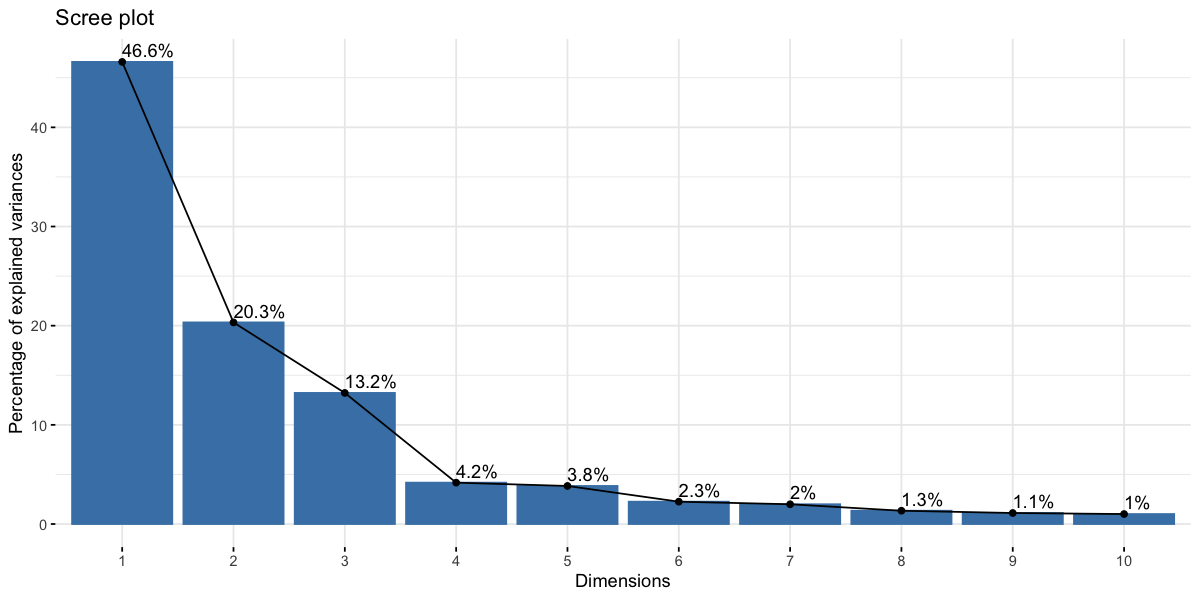

In [11]:
# running PCA
pca = prcomp(pca_prep_df)

# viewing scree plots to see how much of the variance was captured in first 2 eigenvectors
options(repr.plot.width=10, repr.plot.height=5) # changing size
fviz_eig(pca, addlabels = TRUE)

Warning message:
“ggrepel: 11 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


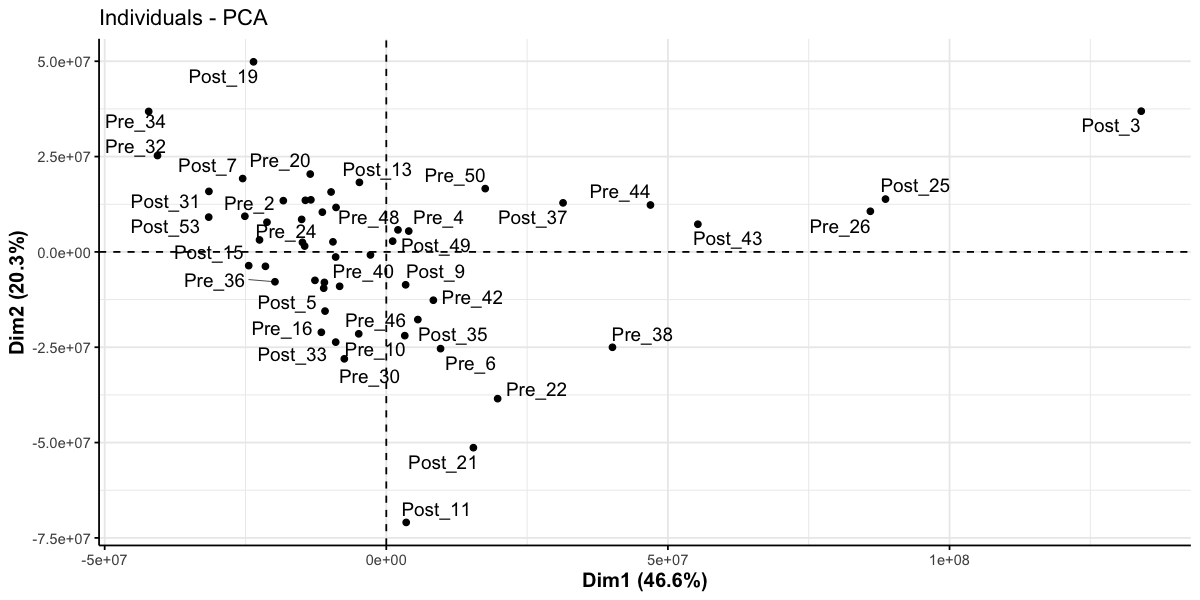

In [12]:
# visualizing all data to detect outliers
fviz_pca_ind(pca, 
             repel = TRUE) +
theme(axis.line = element_line(colour = "black"), #making x and y axes black
      legend.text = element_text(size = 8),
      axis.title = element_text(face = "bold", size = rel(1.1))) #changes axis titles

It looks like Post_3 should be removed, but let's use a quantitative cutoff to ensure others aren't missed. The standard way to detect outliers in genetics is the criterion of being “more than 6 standard deviations away from the mean” [ref](https://privefl.github.io/blog/detecting-outlier-samples-in-pca/). 

In [13]:
outlier_detection = function(pca_df){
    # """
    # Creating a scoring function for to detect PCA sample outliers. 
    # :param (input): PCA df (df)
    # :output: outlier names
    # """
    
    # getting scores
    scores = pca_df$x
    # identifying samples that are > 6 standard deviations away from the mean
    outlier_indices = apply(scores, 2, function(x) which( abs(x - mean(x)) > (6 * sd(x)) )) %>%
        Reduce(union, .)
    # getting sample names
    outliers = rownames(scores)[outlier_indices]
    
    return(outliers)
}

# calling fn
outliers = outlier_detection(pca)
outliers

character(0)

There were no outliers based on the quantitative cut off, so no samples or subjects will be removed. Now we'll create two files to export - one for demographics data and one for proteomics data. 

In [14]:
final_demographics_df = unique(inner_join(demographics_df[,3:13], imputed_df[,1:2])) %>%
    # let's add a column for time point
    mutate(Time_Point = Sample_ID) %>%
    separate(Time_Point, c("Time_Point", NA), sep = "_")

head(final_demographics_df)

Joining, by = "Subject_ID"


,Subject_Number,Subject_ID,Sex,Race,Ethnicity,Age,BMI,Asthma_Status,Pre_Sputum_Neutrophilia,Post_Sputum_Neutrophilia,Responder_Status,Sample_ID,Time_Point
,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,1,NR_1,M,B,NH,37,26.0,NAS,77.20,74.49,NR,Post_1,Post
2245,1,NR_1,M,B,NH,37,26.0,NAS,77.20,74.49,NR,Pre_2,Pre
4489,2,NR_2,F,W,NH,26,21.9,NAS,22.60,0.00,NR,Post_3,Post
6733,2,NR_2,F,W,NH,26,21.9,NAS,22.60,0.00,NR,Pre_4,Pre
8977,3,NR_3,M,W,NH,33,23.9,NAS,68.39,0.00,NR,Post_9,Post
11221,3,NR_3,M,W,NH,33,23.9,NAS,68.39,0.00,NR,Pre_10,Pre


In [15]:
# proteomics data
final_proteomics_df = imputed_df %>%
    select(-Subject_ID) %>%
    pivot_wider(names_from = "Sample_ID", values_from = "Intensity")

head(final_proteomics_df)

Protein_Accession,Post_1,Pre_2,Post_3,Pre_4,Post_9,Pre_10,Post_21,Pre_22,Post_27,⋯,Post_29,Pre_30,Post_47,Pre_48,Post_49,Pre_50,Post_35,Pre_36,Post_39,Pre_40
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
P61626,73788697,81867431,32521079,69466046,50203441,41823327,34975934,34921771,82670310,⋯,78041623,55779739,78017839,66731573,66279750,76021917,49371057,64068496,60666243,66139123
P01877,25112912,39075087,16921860,24640442,49772557,40666198,23305531,15917264,18994462,⋯,23817378,30322565,49411925,37457390,27260646,28569319,33388650,58561266,29945522,30482590
P01876,17621630,34951533,10922385,31606502,32279469,26714576,18441902,15567539,16530104,⋯,29530140,24431671,43629405,28633491,23068196,22846817,21557976,30452171,35312609,28791212
P02768,28010795,13976730,4118811,18642863,17890203,21697353,61371281,37457074,24548903,⋯,22295742,46336832,12366685,14476750,11091174,20545506,26593677,17951898,22630292,24661973
P01834,11670212,22089827,6246719,20170044,17724041,16702856,18224611,10936338,17744128,⋯,18875769,24738676,21207419,17709954,14860626,7980823,19166605,15340119,20452234,22382242
P0DTE7.P0DTE8.P0DUB6,17229358,3912599,129598280,22819125,18337456,10968655,14760964,13339346,2798010,⋯,6584919,4847207,12555813,23199470,7913112,21056958,12648333,1517735,3704294,3869183


In [16]:
# exporting results
write.csv(final_demographics_df, paste0(Output,"/", "Demographics_Data.csv"), row.names = FALSE)
write.csv(final_proteomics_df, paste0(Output,"/", "Proteomics_Data.csv"), row.names = FALSE)